### Steps
1) Drop useless columns <br>
2) Categorical --> Ordinal <br>
3) Impute missing with median <br>
4) CV Baseline RF 100 trees w max depth 5 (metric: AUC) <br> 
5) shap (?) 

In [68]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
data = pd.read_csv('data/aug_train.csv')

In [61]:
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [81]:
#drop useless columns
train = data.drop(['city', 'enrolled_university', 'gender', "major_discipline", "company_type"], axis=1)

In [82]:
def encode(data):
    data['relevant_experience'] = data.relevent_experience.map({'Has relevent experience':1, 'No relevent experience': 0})
    
    education_map = {
        "Primary School": 0,
        "High School": 1,
        "Graduate": 2,
        "Masters": 3,
        "Phd": 4
                 }
    
    size_map = {
        "<10": 0,
        "10/49": 1,
        "50-99": 2,
        "100-500": 3,
        "500-999": 4,
        "1000-4999": 5,
        "5000-9999": 6,
        "10000+": 7
    }
    
    experience_map = {
        '<1':0,
        '>20':21
    }
    
    last_new_job_map = {
        'never': 0,
        '>4': 5
    }
    
    data['education_level'] = data.education_level.map(education_map)
    data['company_size'] = data.company_size.map(size_map)
    data['experience'] = pd.to_numeric(data.experience.map(experience_map))
    data['last_new_job'] = pd.to_numeric(data.last_new_job.map(last_new_job_map))
    data.drop('relevent_experience', axis=1, inplace=True)

In [83]:
encode(train)

In [84]:
#median impute
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median', copy=False)
clean_train = pd.DataFrame(imp_mean.fit_transform(train), columns=train.columns.tolist())

In [132]:
#train_test_split
from sklearn.model_selection import train_test_split

X = clean_train.drop(['enrollee_id', 'target'], axis=1)
y = clean_train.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
#cv auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

baseline = RandomForestClassifier(n_estimators=150, max_depth=5)
scores = cross_val_score(baseline, X_train, y_train, scoring="roc_auc", cv=5)

In [147]:
scores.mean()

0.7747564550001674

In [148]:
baseline.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### TIL: don't forget roc_auc_score uses predict_proba

In [151]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
preds = baseline.predict(X_test)
probs = baseline.predict_proba(X_test)[:,1]
print("accuracy: ", accuracy_score(y_test, preds))
print("roc_auc: ", roc_auc_score(y_test, probs))
print("f1_score: ", f1_score(y_test, preds))

accuracy:  0.7721816283924844
roc_auc:  0.7706380208333333
f1_score:  0.4540337711069418


### AUC Curve

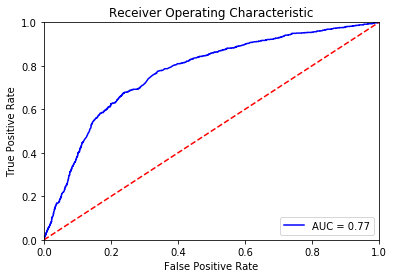

In [155]:
import matplotlib.pyplot as plt  
from sklearn.metrics import roc_curve, auc  

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()